## Time Series Forecasting

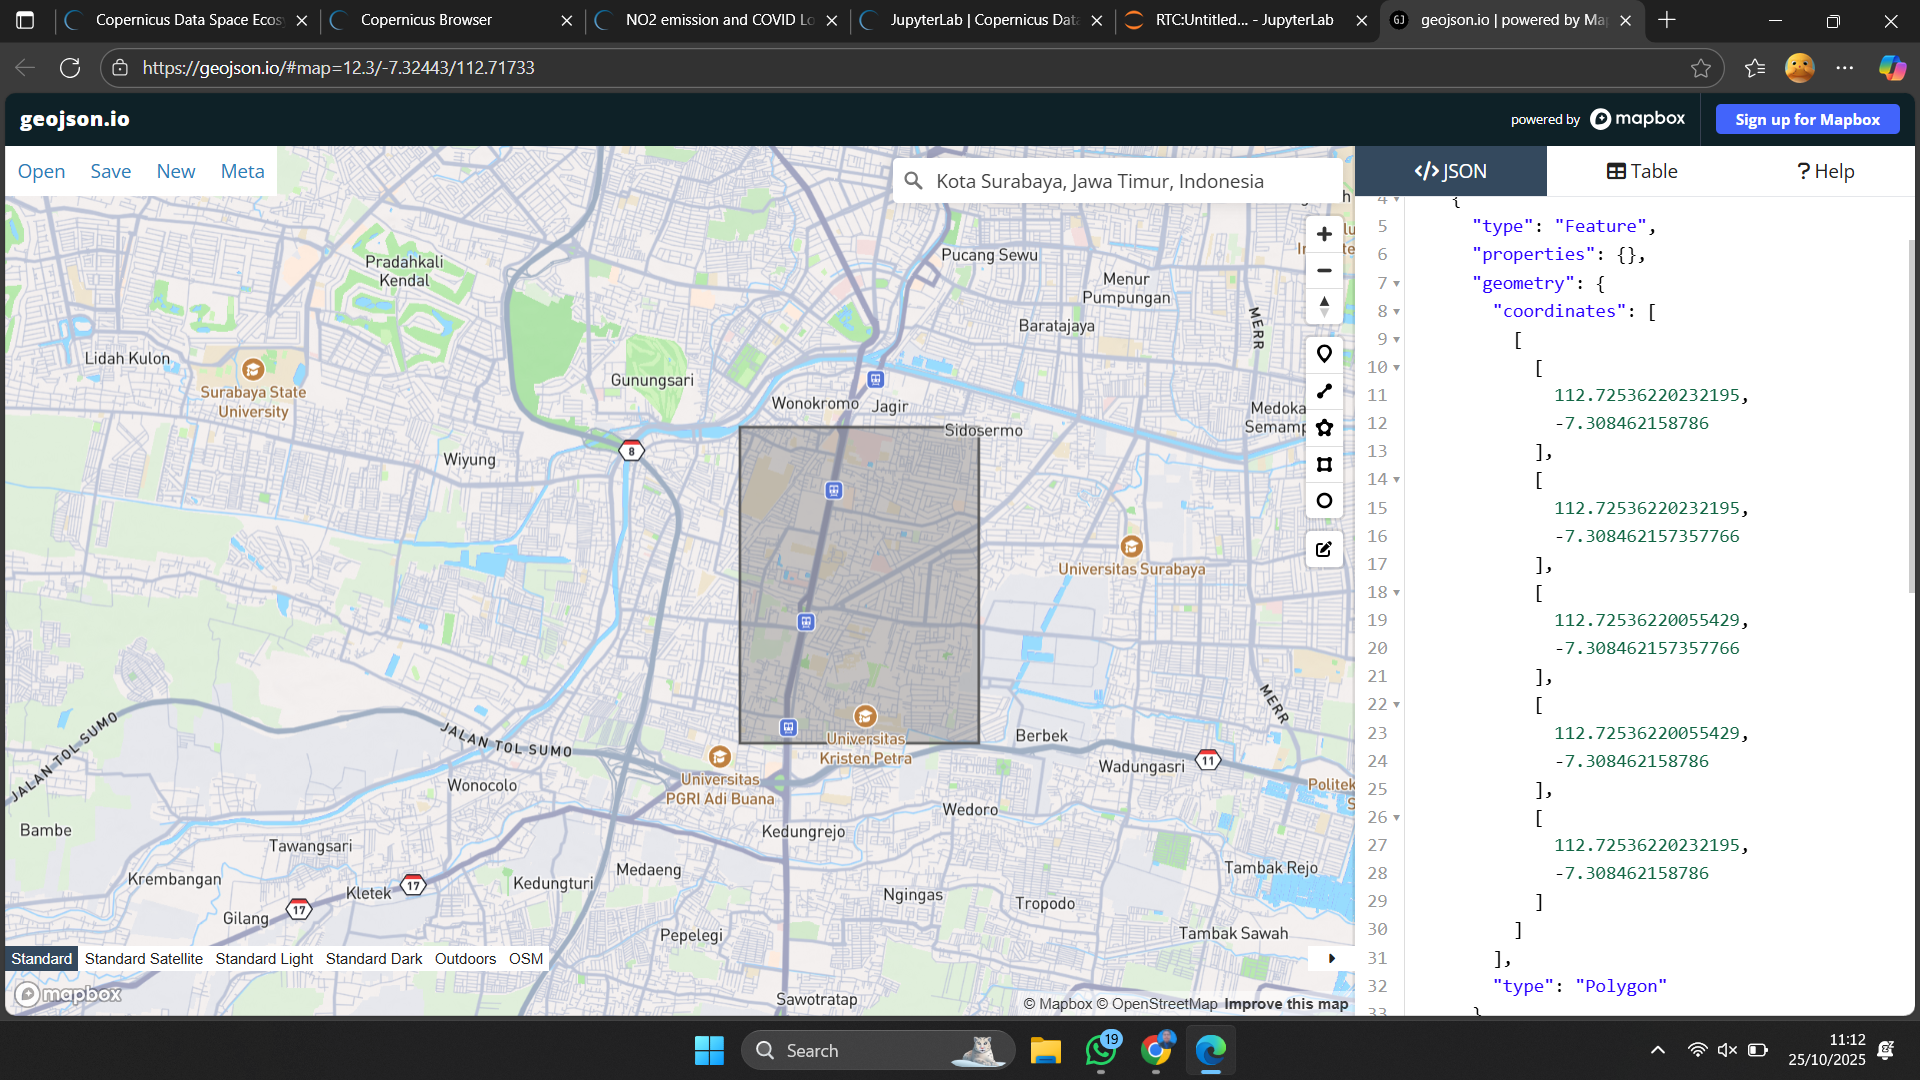

In [1]:
from IPython.display import Image, display
display(Image(filename='Data/peta.png'))


### Mengambil Data

In [2]:
!pip install openeo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [openeo]2m5/6 [openeo]]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [19]:
# === 1️⃣ Instal library (jalankan sekali saja) ===
# !pip install openeo shapely requests

# === 2️⃣ Import library utama ===
import openeo
from shapely.geometry import shape

# === 3️⃣ Koneksi dan autentikasi ke Copernicus openEO ===
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# === 4️⃣ Definisikan area of interest (AOI) valid di sekitar Surabaya ===
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.72, -7.05],
            [112.72, -7.00],
            [112.77, -7.00],
            [112.77, -7.05],
            [112.72, -7.05]
        ]
    ],
}

# === 5️⃣ Load koleksi Sentinel-5P (L2 NO2) untuk rentang waktu tertentu ===
# Gunakan rentang singkat dulu untuk uji coba agar tidak overload
prob = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-10-25", "2025-10-25"], 
    spatial_extent={
        "west": 112.72,
        "south": -7.05,
        "east": 112.77,
        "north": -7.00
    },
    bands=["NO2"]
)

# === 6️⃣ Agregasi temporal harian ===
prob = prob.aggregate_temporal_period(reducer="mean", period="day")

# === 7️⃣ Agregasi spasial berdasarkan AOI ===
feature = {"type": "Feature", "geometry": aoi, "properties": {"id": 1}}
fc = {"type": "FeatureCollection", "features": [feature]}
prob = prob.aggregate_spatial(reducer="mean", geometries=fc)

# === 8️⃣ Eksekusi batch job dan unduh hasil ===
try:
    job = prob.execute_batch(
        title="NO2 Surabaya 25 Oktober 2023 - 25 Oktober 2025",
        outputfile="no2_surabaya.nc"  # hasil disimpan di file .nc
    )
    print("✅ Job selesai sukses:", job.status())

except Exception as e:
    print("❌ Terjadi error:", e)
    # Jika job gagal, coba ambil log-nya
    try:
        job_id = str(e).split("'")[1]
        job = connection.job(job_id)
        print("🔍 Log job:\n", job.logs())
    except:
        print("Tidak bisa membaca log job secara otomatis.")


Authenticated using refresh token.
0:00:00 Job 'j-25102507010641fdba19eb1cffb44415': send 'start'
0:00:13 Job 'j-25102507010641fdba19eb1cffb44415': created (progress 0%)
0:00:18 Job 'j-25102507010641fdba19eb1cffb44415': created (progress 0%)
0:00:25 Job 'j-25102507010641fdba19eb1cffb44415': created (progress 0%)
0:00:33 Job 'j-25102507010641fdba19eb1cffb44415': created (progress 0%)
0:00:43 Job 'j-25102507010641fdba19eb1cffb44415': created (progress 0%)
0:00:56 Job 'j-25102507010641fdba19eb1cffb44415': created (progress 0%)
0:01:11 Job 'j-25102507010641fdba19eb1cffb44415': running (progress N/A)
0:01:31 Job 'j-25102507010641fdba19eb1cffb44415': running (progress N/A)
0:01:55 Job 'j-25102507010641fdba19eb1cffb44415': running (progress N/A)
0:02:26 Job 'j-25102507010641fdba19eb1cffb44415': running (progress N/A)
0:03:04 Job 'j-25102507010641fdba19eb1cffb44415': running (progress N/A)
0:03:50 Job 'j-25102507010641fdba19eb1cffb44415': running (progress N/A)
0:04:49 Job 'j-25102507010641fdb

### Convert to CSV

In [20]:
!pip install netCDF4 h5netcdf xarray --upgrade --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [21]:
import xarray as xr
import pandas as pd

# === Buka file NetCDF hasil openEO ===
ds = xr.open_dataset("/workspaces/PSD/PSD/no2_surabaya.nc", engine="h5netcdf")

# === Lihat struktur dataset ===
print(ds)

# === Konversi ke DataFrame ===
df = ds.to_dataframe().reset_index()

# === Deteksi otomatis kolom waktu dan NO2 ===
kolom_waktu = 't' if 't' in df.columns else 'time'
kolom_no2 = 'NO2' if 'NO2' in df.columns else list(df.filter(like='NO2'))[0]

# === Pilih kolom utama ===
df = df[[kolom_waktu, kolom_no2]]
df.columns = ['Tanggal', 'NO2']

# === Simpan hasil ke CSV ===
output_path = "/workspaces/PSD/PSD/Data/NO2_Surabaya.csv"
df.to_csv(output_path, index=False)

print(f"✅ Data berhasil disimpan ke: {output_path}")
print(df.head())


<xarray.Dataset> Size: 5kB
Dimensions:        (feature: 1, t: 301)
Coordinates:
  * t              (t) datetime64[ns] 2kB 2023-10-25 2023-10-26 ... 2025-10-19
    lat            (feature) float64 8B ...
    lon            (feature) float64 8B ...
    feature_names  (feature) int64 8B ...
Dimensions without coordinates: feature
Data variables:
    NO2            (feature, t) float64 2kB ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.
✅ Data berhasil disimpan ke: /workspaces/PSD/PSD/Data/NO2_Surabaya.csv
     Tanggal       NO2
0 2023-10-25  0.000026
1 2023-10-26  0.000066
2 2023-10-27  0.000048
3 2023-10-29  0.000052
4 2023-10-30  0.000055


### Exploratory Data Analysis (EDA)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
no2_asli = pd.read_csv("/workspaces/PSD/PSD/Data/NO2_Surabaya.csv")
no2_asli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  301 non-null    object 
 1   NO2      301 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.8+ KB


In [23]:
# Ubah kolom 'Tanggal' menjadi tipe Tanggaltime
no2_asli['Tanggal'] = pd.to_datetime(no2_asli['Tanggal'])
no2_asli.info()

no2 = no2_asli.copy()

# Urutkan data berdasarkan tanggal
no2 = no2.sort_values('Tanggal')

# Set kolom 'Tanggal' sebagai index
no2 = no2.set_index('Tanggal')
print(no2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  301 non-null    datetime64[ns]
 1   NO2      301 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB
                 NO2
Tanggal             
2023-10-25  0.000026
2023-10-26  0.000066
2023-10-27  0.000048
2023-10-29  0.000052
2023-10-30  0.000055


In [24]:
# MEMERIKSA MISSING DATES

# Cek rentang tanggal lengkap (harian)
tanggal_lengkap = pd.date_range(start=no2.index.min(), end=no2.index.max(), freq='D')

print(tanggal_lengkap)

# Cari tanggal yang hilang
tanggal_hilang = tanggal_lengkap.difference(no2.index)

print("Tanggal yang hilang:\n", tanggal_hilang)

DatetimeIndex(['2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28',
               '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01',
               '2023-11-02', '2023-11-03',
               ...
               '2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-19'],
              dtype='datetime64[ns]', length=726, freq='D')
Tanggal yang hilang:
 DatetimeIndex(['2023-10-28', '2023-11-03', '2023-11-04', '2023-11-11',
               '2023-11-13', '2023-11-21', '2023-11-23', '2023-11-24',
               '2023-11-25', '2023-11-28',
               ...
               '2025-10-01', '2025-10-05', '2025-10-06', '2025-10-11',
               '2025-10-12', '2025-10-13', '2025-10-15', '2025-10-16',
               '2025-10-17', '2025-10-18'],
              dtype='datetime64[ns]', length=425, freq=None)


## Pre-Processing

### Menangani Missing Value

In [25]:
# Reindex dataframe agar semua tanggal muncul
no2 = no2.reindex(tanggal_lengkap)
print(no2.head(10))

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Reset index dan ubah nama kolom index ke 'date' kembali
no2 = no2.reset_index().rename(columns={'index': 'Tanggal'})

# Cek hasil
# print(no2.head())
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

                 NO2
2023-10-25  0.000026
2023-10-26  0.000066
2023-10-27  0.000048
2023-10-28       NaN
2023-10-29  0.000052
2023-10-30  0.000055
2023-10-31  0.000044
2023-11-01  0.000027
2023-11-02  0.000049
2023-11-03       NaN

Jumlah missing value setelah interpolasi:
Tanggal    0
NO2        0
dtype: int64


In [26]:
# Reindex dataframe agar semua tanggal muncul
no2 = no2.reindex(tanggal_lengkap)
print(no2.head(10))

# Interpolasi nilai yang hilang (linear interpolation)
no2 = no2.interpolate(method='linear')

# Reset index dan ubah nama kolom index ke 'date' kembali
no2 = no2.reset_index().rename(columns={'index': 'Tanggal'})

# Cek hasil
# print(no2.head())
print("\nJumlah missing value setelah interpolasi:")
print(no2.isna().sum())

           Tanggal  NO2
2023-10-25     NaT  NaN
2023-10-26     NaT  NaN
2023-10-27     NaT  NaN
2023-10-28     NaT  NaN
2023-10-29     NaT  NaN
2023-10-30     NaT  NaN
2023-10-31     NaT  NaN
2023-11-01     NaT  NaN
2023-11-02     NaT  NaN
2023-11-03     NaT  NaN

Jumlah missing value setelah interpolasi:
Tanggal      0
Tanggal    726
NO2        726
dtype: int64


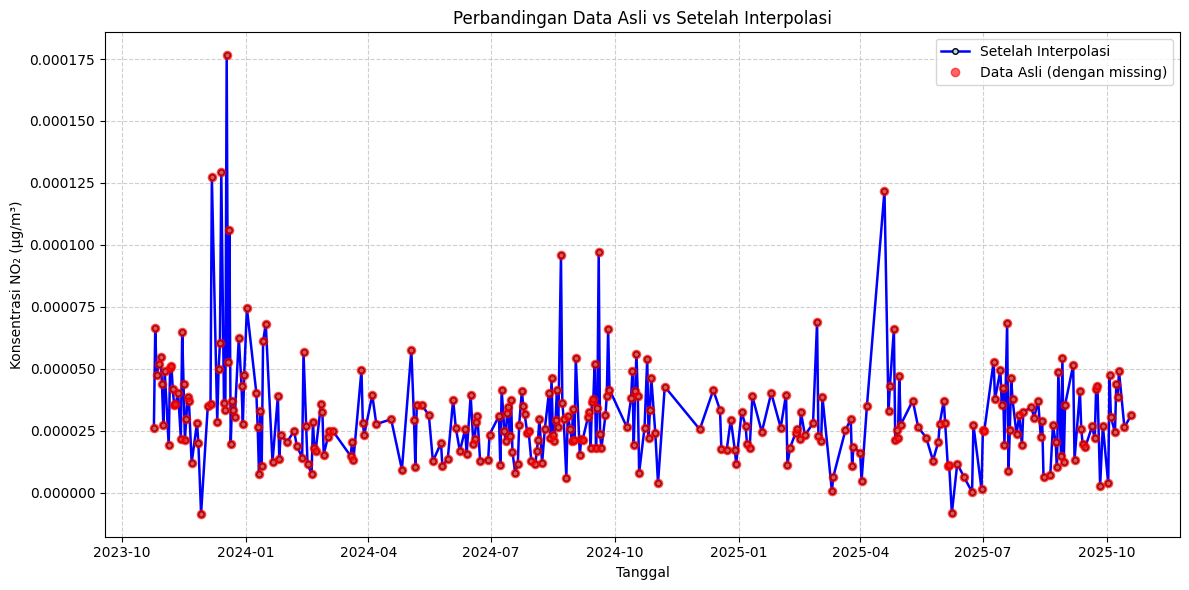

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# pastikan format tanggal dan urutkan
no2['Tanggal'] = pd.to_datetime(no2['Tanggal'])
no2_asli['Tanggal'] = pd.to_datetime(no2_asli['Tanggal'])
no2 = no2.sort_values('Tanggal')
no2_asli = no2_asli.sort_values('Tanggal')

plt.figure(figsize=(12, 6))

# Garis interpolasi (biru dengan garis abu-abu)
plt.plot(
    no2['Tanggal'], 
    no2['NO2'], 
    color='blue', 
    linewidth=1.8, 
    marker='o', 
    markersize=4, 
    markeredgecolor='black', 
    markerfacecolor='lightblue', 
    label='Setelah Interpolasi'
)

# Titik data asli (merah tanpa garis)
plt.plot(
    no2_asli['Tanggal'], 
    no2_asli['NO2'], 
    'ro', 
    alpha=0.6, 
    label='Data Asli (dengan missing)'
)

plt.title('Perbandingan Data Asli vs Setelah Interpolasi')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Mengubah Data menjadi Supervised

In [35]:
import pandas as pd

# === 1️⃣ Baca data NO₂ ===
no2 = pd.read_csv("/workspaces/PSD/PSD/Data/NO2_Surabaya.csv")

print(no2.head())
print(no2.columns)

# Pastikan kolom NO2 ada
kolom_no2 = 'NO2' if 'NO2' in no2.columns else list(no2.filter(like='NO2'))[0]

# === 2️⃣ Ubah ke data supervised ===
supervised = pd.DataFrame()
supervised['t-4'] = no2[kolom_no2].shift(4)
supervised['t-3'] = no2[kolom_no2].shift(3)
supervised['t-2'] = no2[kolom_no2].shift(2)
supervised['t-1'] = no2[kolom_no2].shift(1)
supervised['t']   = no2[kolom_no2]

# === 3️⃣ Hapus nilai NaN hasil shift ===
supervised = supervised.dropna().reset_index(drop=True)

# === 4️⃣ Cek hasil ===
print("Jumlah data supervised:", len(supervised))
print(supervised.head(10))


      Tanggal       NO2
0  2023-10-25  0.000026
1  2023-10-26  0.000066
2  2023-10-27  0.000048
3  2023-10-29  0.000052
4  2023-10-30  0.000055
Index(['Tanggal', 'NO2'], dtype='object')
Jumlah data supervised: 297
        t-4       t-3       t-2       t-1         t
0  0.000026  0.000066  0.000048  0.000052  0.000055
1  0.000066  0.000048  0.000052  0.000055  0.000044
2  0.000048  0.000052  0.000055  0.000044  0.000027
3  0.000052  0.000055  0.000044  0.000027  0.000049
4  0.000055  0.000044  0.000027  0.000049  0.000019
5  0.000044  0.000027  0.000049  0.000019  0.000050
6  0.000027  0.000049  0.000019  0.000050  0.000051
7  0.000049  0.000019  0.000050  0.000051  0.000042
8  0.000019  0.000050  0.000051  0.000042  0.000036
9  0.000050  0.000051  0.000042  0.000036  0.000036


### Normalisasi Data

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_values = scaler.fit_transform(supervised)
scaled = pd.DataFrame(scaled_values, columns=supervised.columns)

print(scaled.head())

        t-4       t-3       t-2       t-1         t
0  0.187869  0.404131  0.303341  0.327589  0.342970
1  0.404131  0.303341  0.327589  0.342970  0.283016
2  0.303341  0.327589  0.342970  0.283016  0.194044
3  0.327589  0.342970  0.283016  0.194044  0.312344
4  0.342970  0.283016  0.194044  0.312344  0.149180


### Modeling

In [37]:
X = scaled.drop('t', axis=1)
y = scaled['t']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 0.0098
R^2 Score: -0.0327


In [38]:
result = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

print("\nContoh hasil prediksi:")
print(result.head())


Contoh hasil prediksi:
     Actual  Predicted
0  0.169176   0.217361
1  0.158223   0.160513
2  0.254566   0.215780
3  0.049314   0.261727
4  0.080434   0.187234


In [39]:
last_input = scaled.drop('t', axis=1).iloc[-1].values.reshape(1, -1)
next_pred_scaled = knn.predict(last_input)
next_pred = scaler.inverse_transform(
    np.hstack((last_input, next_pred_scaled.reshape(-1, 1)))
)[0, -1]

# Buat tanggal baru untuk prediksi
next_date = (pd.to_datetime(no2['Tanggal'].iloc[-1]) + pd.Timedelta(days=1)).date()

print(f'\nPrediksi NO2 pada {next_date}: {next_pred}')


Prediksi NO2 pada 2025-10-20: 3.5975426726508886e-05


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


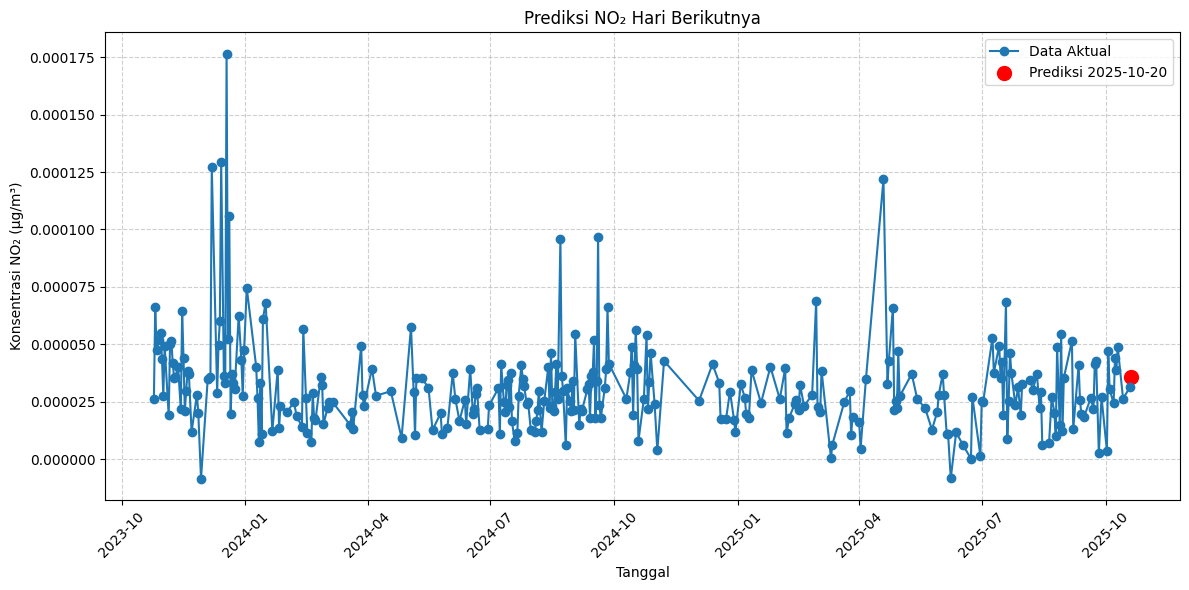

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# === Pastikan tipe waktu konsisten ===
# ubah kolom tanggal menjadi datetime64 agar sumbu X bisa dibaca
no2['Tanggal'] = pd.to_datetime(no2['Tanggal'])

# ubah next_date (prediksi hari berikutnya) ke Timestamp juga
next_date = pd.to_datetime(next_date)

# === Plot data aktual + prediksi ===
plt.figure(figsize=(12, 6))
plt.plot(no2['Tanggal'], no2['NO2'], marker='o', label='Data Aktual')

# pastikan next_pred berupa angka tunggal (bukan list)
plt.scatter([next_date], [float(next_pred)], color='red', s=100,
            label=f'Prediksi {next_date.strftime("%Y-%m-%d")}')

plt.title('Prediksi NO₂ Hari Berikutnya')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂ (µg/m³)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
